# Fireveg DB - plot of fire history per sampling location

Author: [José R. Ferrer-Paris](https://github.com/jrfep) and [Ada Sánchez-Mercado](https://github.com/adasanchez)

Date: July 2024

This Jupyter Notebook includes **R code to analyse and visualise** data exported from the Fireveg Database. 

Here we will read input from a public data record of the database to answer some questions about the data coverage of the database.

```mermaid
flowchart LR
    Litrev & Form  --> Fireveg --> DR --> Code --> Q1 & Q2 & Q3
    Fireveg[(Fireveg\nDatabase)]
    Litrev[Field work\ndata stream] 
    Form[Existing sources\n data stream] 
    BioNet(BioNet Atlas\nSpecies list) 
    BioNet -.-> Fireveg
    DR[Exported\nData Record\nVersion 1.1]
    Code{R code\nfor analysis}:::ThisRepo
    Q1[Q1. ...]
    Q2["Q2. ..."]
    Q3["Q3. Sampling related to time since fire"]:::ThisRepo      
classDef ThisRepo fill:none,stroke:black,color:black;

```

In this notebook we will explore the **timing of field visits in relation to time since fire disaggregated by surveys**.

## Set-up

### Load packages

In [1]:
library(ggplot2)
library(forcats)
library(dplyr)
library(data.table)
library(sf)
library(tidyr)
library(ozmaps)
library(ggrepel)
library(ggpubr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



For data download from cloud storage

In [2]:
require(osfr)
library(jsonlite)

Loading required package: osfr

Automatically registered OSF personal access token



### Paths for inputs and outputs

Set working directory

In [3]:
here::i_am("Notebooks/Fire-history-field-visits.ipynb")

here() starts at /Users/z3529065/proyectos/fireveg/fireveg-analysis



In [4]:
data_dir <- here::here("data")
if (!dir.exists(data_dir))
    dir.create(data_dir)

### Download data from OSF

<div class="alert alert-info">
     <img src='../img/open-data-2.png' width=25 alt="open data icon"/>
Data for this Notebook is available from the following OSF repository:

> Ferrer-Paris, J. R., Keith, D., & Sánchez-Mercado, A. (2024, August 15). Export data records from Fire Ecology Traits for Plants database. Retrieved from [osf.io/h96q2](https://osf.io/h96q2/)
</div>

Here we will download data programmatically from OSF cloud storage to our local data folder. First we will check the metadata for the target file. We use the `osf_ls_files` function from package `osfr` to explore the metadata of the file associated to the OSF component.

In [5]:
osf_project <- osf_retrieve_node("https://osf.io/h96q2")
file_list <- osf_ls_files(osf_project)

In [6]:
select(file_list, name, id)

name,id
<chr>,<chr>
fire-history.rds,6452ba9d13904f00b7fc85d2
Quadrat-sample-data.rds,6452bab38ea16b0093b69427
site-visits.rds,6452bac07177850087b0f73c
Summary-traits-family.rds,6452bacfb30b4900b4b9ddc4
Summary-traits-species.rds,6452bae3717785008bb0f4b1
field-sites.gpkg,648a583bbee36d028d0e6261
Summary-traits-sources.rds,64966f6fa2a2f4075a436743
Trait-info.rds,649a64e8a2a2f40aa7436407
References-traits-sources.rds,66c8198039554f1e062d2f46


Selection of files to download

In [7]:
files_to_download <- c(
    "Quadrat-sample-data.rds",
    "fire-history.rds", 
    "site-visits.rds", 
    "field-sites.gpkg"
)

In [8]:
selected_files <- filter(file_list, name %in% files_to_download)

To download the latest version we apply the `osf_download` function with option `conflicts="overwrite"`. 
If we already have the latest version we can choose option `conflicts="skip"`.

In [9]:
downloaded_files <- osf_download(selected_files,
             data_dir,
             conflicts = "overwrite")


**What about older versions?**

We can request more complete version information with a direct call to the API using the `read_json` function:

In [10]:
file_versions <- read_json(downloaded_files$meta[[1]]$relationships$versions$links$related$href)

In [11]:
file_versions

$data
$data[[1]]
$data[[1]]$id
[1] "6"

$data[[1]]$type
[1] "file_versions"

$data[[1]]$attributes
$data[[1]]$attributes$size
[1] 2202

$data[[1]]$attributes$content_type
[1] "application/octet-stream"

$data[[1]]$attributes$date_created
[1] "2024-08-27T04:52:56.573952"

$data[[1]]$attributes$name
[1] "fire-history.rds"


$data[[1]]$links
$data[[1]]$links$self
[1] "https://api.osf.io/v2/files/6452ba9d13904f00b7fc85d2/versions/6/"

$data[[1]]$links$html
[1] "https://osf.io/h96q2/files/osfstorage/6452ba9d13904f00b7fc85d2?revision=6"

$data[[1]]$links$download
[1] "https://osf.io/download/6452ba9d13904f00b7fc85d2/?revision=6"

$data[[1]]$links$render
[1] "https://mfr.au-1.osf.io/render?url=https%3A%2F%2Fosf.io%2Fdownload%2F6452ba9d13904f00b7fc85d2%2F%3Frevision%3D6%26direct%26mode%3Drender"



$data[[2]]
$data[[2]]$id
[1] "5"

$data[[2]]$type
[1] "file_versions"

$data[[2]]$attributes
$data[[2]]$attributes$size
[1] 1757

$data[[2]]$attributes$content_type
[1] "application/octet-stream"

$data[[2]]$attributes$date_created
[1] "2024-08-27T04:25:11.308467"

$data[[2]]$attributes$name
[1] "fire-history.rds"


$data[[2]]$links
$data[[2]]$links$self
[1] "https://api.osf.io/v2/files/6452ba9d13904f00b7fc85d2/versions/5/"

$data[[2]]$links$html
[1] "https://osf.io/h96q2/files/osfstorage/6452ba9d13904f00b7fc85d2?revision=5"

$data[[2]]$links$download
[1] "https://osf.io/download/6452ba9d13904f00b7fc85d2/?revision=5"

$data[[2]]$links$render
[1] "https://mfr.au-1.osf.io/render?url=https%3A%2F%2Fosf.io%2Fdownload%2F6452ba9d13904f00b7fc85d2%2F%3Frevision%3D5%26direct%26mode%3Drender"



$data[[3]]
$data[[3]]$id
[1] "4"

$data[[3]]$type
[1] "file_versions"

$data[[3]]$attributes
$data[[3]]$attributes$size
[1] 2328

$data[[3]]$attributes$content_type
[1] "application/octet-stream"

$data[[3]]$attributes$date_created
[1] "2024-08-22T12:27:28.942999"

$data[[3]]$attributes$name
[1] "fire-history.rds"


$data[[3]]$links
$data[[3]]$links$self
[1] "https://api.osf.io/v2/files/6452ba9d13904f00b7fc85d2/versions/4/"

$data[[3]]$links$html
[1] "https://osf.io/h96q2/files/osfstorage/6452ba9d13904f00b7fc85d2?revision=4"

$data[[3]]$links$download
[1] "https://osf.io/download/6452ba9d13904f00b7fc85d2/?revision=4"

$data[[3]]$links$render
[1] "https://mfr.au-1.osf.io/render?url=https%3A%2F%2Fosf.io%2Fdownload%2F6452ba9d13904f00b7fc85d2%2F%3Frevision%3D4%26direct%26mode%3Drender"



$data[[4]]
$data[[4]]$id
[1] "3"

$data[[4]]$type
[1] "file_versions"

$data[[4]]$attributes
$data[[4]]$attributes$size
[1] 2491

$data[[4]]$attributes$content_type
[1] "application/octet-stream"

$data[[4]]$attributes$date_created
[1] "2024-08-14T21:44:58.798080"

$data[[4]]$attributes$name
[1] "fire-history.rds"


$data[[4]]$links
$data[[4]]$links$self
[1] "https://api.osf.io/v2/files/6452ba9d13904f00b7fc85d2/versions/3/"

$data[[4]]$links$html
[1] "https://osf.io/h96q2/files/osfstorage/6452ba9d13904f00b7fc85d2?revision=3"

$data[[4]]$links$download
[1] "https://osf.io/download/6452ba9d13904f00b7fc85d2/?revision=3"

$data[[4]]$links$render
[1] "https://mfr.au-1.osf.io/render?url=https%3A%2F%2Fosf.io%2Fdownload%2F6452ba9d13904f00b7fc85d2%2F%3Frevision%3D3%26direct%26mode%3Drender"



$data[[5]]
$data[[5]]$id
[1] "2"

$data[[5]]$type
[1] "file_versions"

$data[[5]]$attributes
$data[[5]]$attributes$size
[1] 2490

$data[[5]]$attributes$content_type
[1] "application/octet-stream"

$data[[5]]$attributes$date_created
[1] "2023-06-01T04:39:15.314018"

$data[[5]]$attributes$name
[1] "fire-history.rds"


$data[[5]]$links
$data[[5]]$links$self
[1] "https://api.osf.io/v2/files/6452ba9d13904f00b7fc85d2/versions/2/"

$data[[5]]$links$html
[1] "https://osf.io/h96q2/files/osfstorage/6452ba9d13904f00b7fc85d2?revision=2"

$data[[5]]$links$download
[1] "https://osf.io/download/6452ba9d13904f00b7fc85d2/?revision=2"

$data[[5]]$links$render
[1] "https://mfr.au-1.osf.io/render?url=https%3A%2F%2Fosf.io%2Fdownload%2F6452ba9d13904f00b7fc85d2%2F%3Frevision%3D2%26direct%26mode%3Drender"



$data[[6]]
$da

In [12]:
results <- lapply(file_versions$data, function(x) {
    sprintf("version id %s from %s available at %s\n",
            x$id,
            x$attributes$date_created,
            x$links$download)
})
for (res in results) 
    cat(res)

version id 6 from 2024-08-27T04:52:56.573952 available at https://osf.io/download/6452ba9d13904f00b7fc85d2/?revision=6
version id 5 from 2024-08-27T04:25:11.308467 available at https://osf.io/download/6452ba9d13904f00b7fc85d2/?revision=5
version id 4 from 2024-08-22T12:27:28.942999 available at https://osf.io/download/6452ba9d13904f00b7fc85d2/?revision=4
version id 3 from 2024-08-14T21:44:58.798080 available at https://osf.io/download/6452ba9d13904f00b7fc85d2/?revision=3
version id 2 from 2023-06-01T04:39:15.314018 available at https://osf.io/download/6452ba9d13904f00b7fc85d2/?revision=2
version id 1 from 2023-05-03T19:48:45.126074 available at https://osf.io/download/6452ba9d13904f00b7fc85d2/?revision=1


### Read data from local folder

The data is now available in our local data folder and we can use `readRDS` to read these files into our R session, 

In [13]:
firehistory_table <- readRDS(here::here(data_dir,"fire-history.rds")) |> mutate(site_label=factor(site_label))
quadrats_table <- readRDS(here::here(data_dir,"Quadrat-sample-data.rds"))
visits_table <- readRDS(here::here(data_dir,"site-visits.rds"))

We use `read_sf` to read spatial vector data:

In [14]:
site_locs <- read_sf(here::here(data_dir,"field-sites.gpkg"))

## Visualisation of fire history

In [15]:
site_visit_firehistory <- 
  firehistory_table |> 
  group_by(site_label) |>
  summarise(nfires=n(),
            first_fire=min(earliest_date),
            date1=max(earliest_date),date2=max(latest_date)) |>
  left_join(visits_table, by="site_label", relationship = "one-to-many") |>
  mutate(
    time_min=visit_date-date2, 
    time_max=visit_date-date1,
    month1=month(date1),
    month2=month(date2)) |>
  filter(time_min >= 0,time_max < 1000, month1==month2)  

In [16]:
dim(firehistory_table)

[1] 275   5

Don't know how to automatically pick scale for object of type <difftime>.
Defaulting to continuous.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


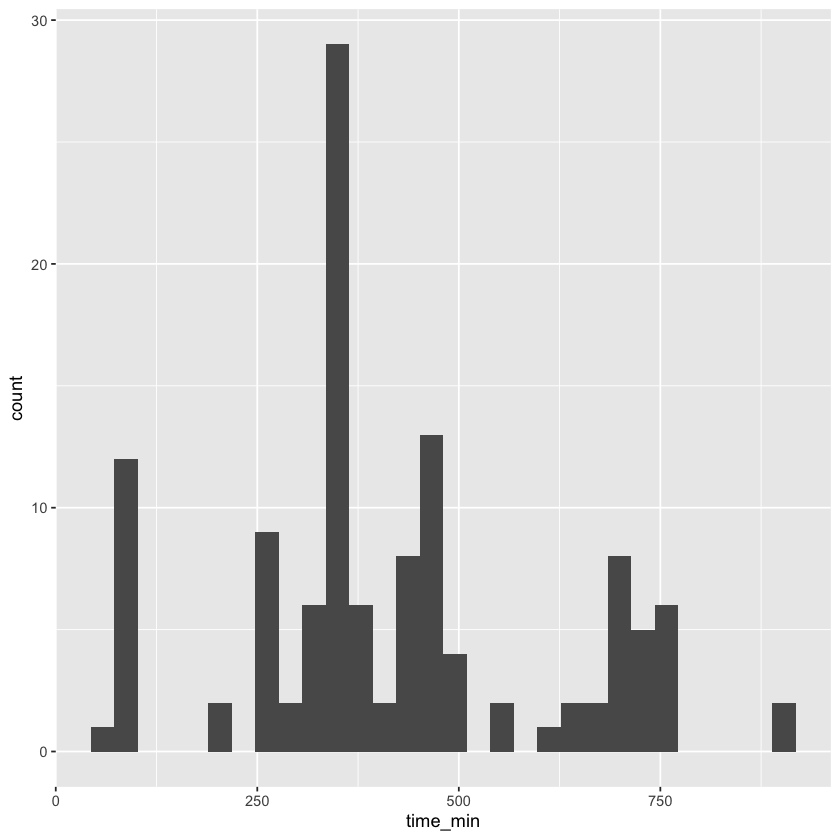

In [17]:
ggplot(site_visit_firehistory) +
    geom_histogram(aes(x=time_min)) 

In [28]:
site_visit_firehistory |>
    filter(time_min <100)

site_label,nfires,first_fire,date1,date2,visit_date,time_min,time_max,month1,month2
<chr>,<int>,<date>,<date>,<date>,<date>,<drtn>,<drtn>,<int>,<int>
BS2,1,2020-01-01,2020-01-01,2020-01-01,2020-03-06,65 days,65 days,1,1
CW1,1,2019-12-16,2019-12-16,2019-12-16,2020-03-04,79 days,79 days,12,12
CW2,1,2019-12-16,2019-12-16,2019-12-16,2020-03-04,79 days,79 days,12,12
GGE1,1,2019-12-16,2019-12-16,2019-12-16,2020-03-05,80 days,80 days,12,12
GGE2,1,2019-12-16,2019-12-16,2019-12-16,2020-03-05,80 days,80 days,12,12
GGW1,1,2019-12-16,2019-12-16,2019-12-16,2020-03-04,79 days,79 days,12,12
GGW2,1,2019-12-16,2019-12-16,2019-12-16,2020-03-04,79 days,79 days,12,12
HV1,1,2019-12-16,2019-12-16,2019-12-16,2020-03-05,80 days,80 days,12,12
HV2,1,2019-12-16,2019-12-16,2019-12-16,2020-03-05,80 days,80 days,12,12


In [19]:
firehistory_table |> filter(site_label %in% "AUSALPS_NSW038")

site_label,earliest_date,latest_date,how_inferred,cause_of_ignition
<fct>,<date>,<date>,<chr>,<chr>
AUSALPS_NSW038,2003-01-01,2003-12-31,NA,Lightning
AUSALPS_NSW038,2020-01-01,2020-01-31,NA,Lightning


In [20]:
visits_table |> filter(site_label %in% "AUSALPS_NSW038")

site_label,visit_date
<chr>,<date>
AUSALPS_NSW038,2021-11-01


In [36]:
site_visit_firehistory <- site_visit_firehistory |>
    mutate(survey_name = site_locs$survey_name[match(site_label, site_locs$site_label)]) |>
    mutate(survey_group = if_else(
        survey_name %in% "Mallee Woodlands",
            "Western NSW",
            "Eastern NSW"))

This plot only includes time since most recent fire:

Don't know how to automatically pick scale for object of type <difftime>.
Defaulting to continuous.


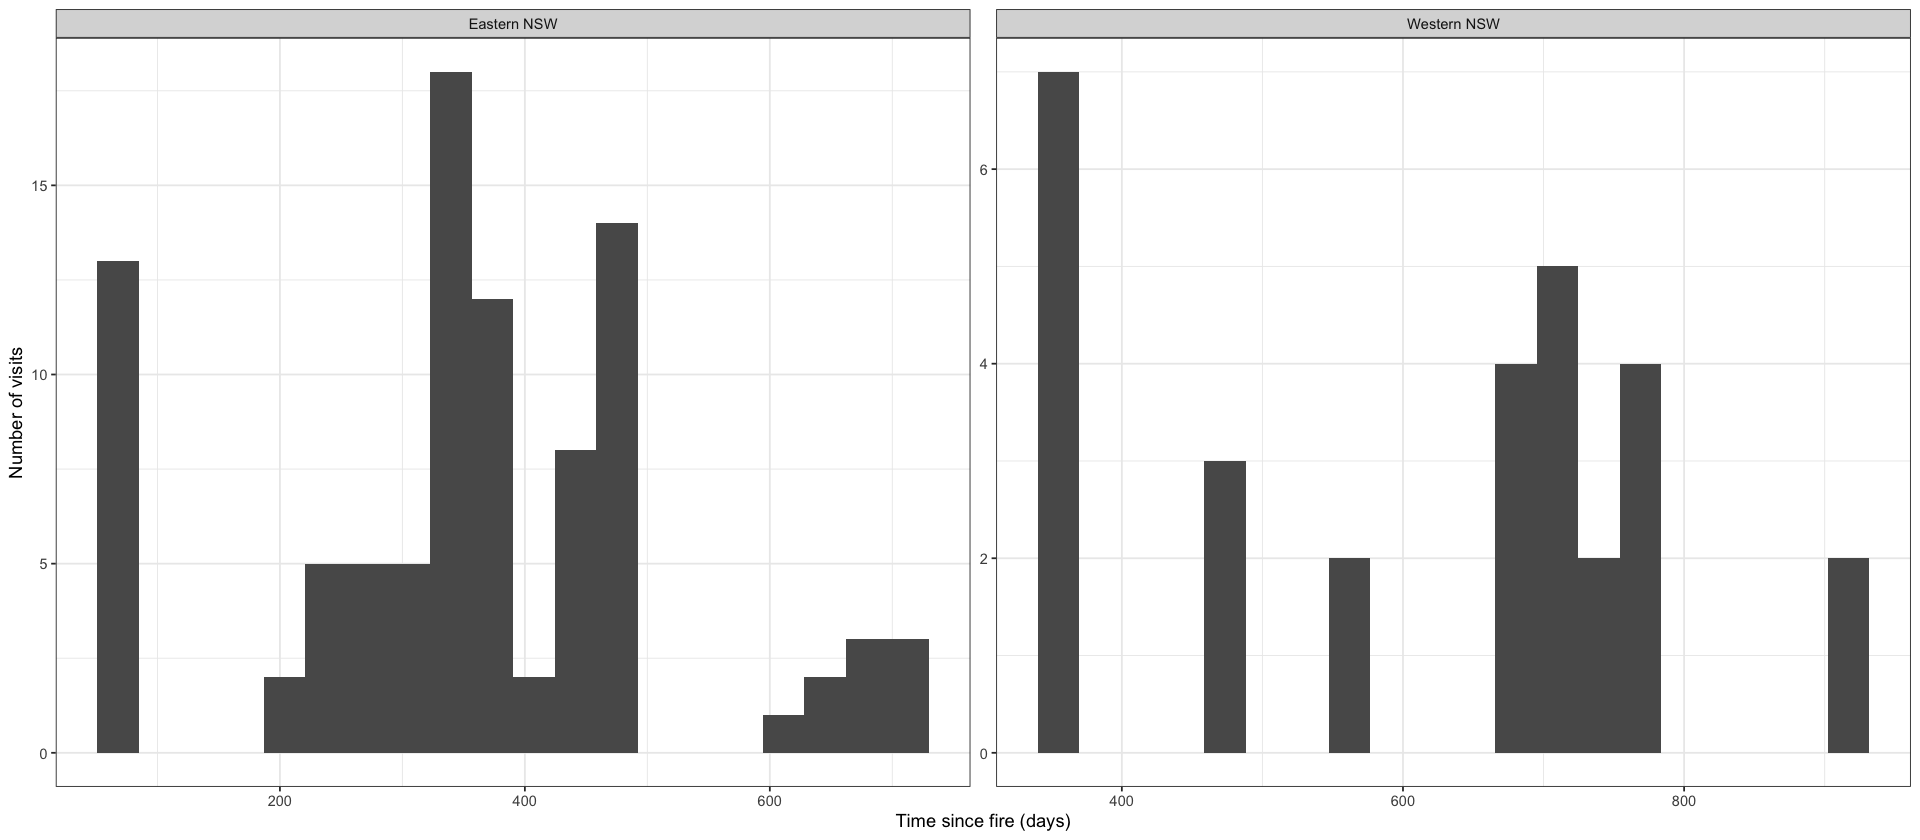

In [37]:
options(repr.plot.width=16) # Make plot larger

ggplot(site_visit_firehistory,
  aes(
    x = time_min,
  )) +
  geom_histogram(bins = 20) +
  facet_wrap(~ survey_group, scales ="free") +
  theme(legend.position = "none") +
  labs(x = "Time since fire (days)", y = "Number of visits") +
  theme_bw()

In [21]:
included <- c("Mallee Woodlands")
excluded <- c( "TO BE CLASSIFIED")
field_surveys <- site_locs |> 
         filter(!survey_name %in% excluded)

In [22]:
survey_cts <- field_surveys |> 
  group_by(survey_name,survey_description) |> 
  summarise(
    nsites=n(),
    geom=st_union(geom),.groups='keep') |> 
  st_centroid()
xys <- st_coordinates(survey_cts) |> data.frame()
xys$survey_name <- survey_cts$survey_name
xys$survey_desc <- survey_cts |> 
  transmute(
    description=sprintf(
      "%s\n%s sites",
      survey_description, nsites
      )) |>
  pull(description)


In [23]:
 fire_visits_data <- firehistory_table %>% 
  transmute(site_label,
    date = earliest_date,
    event = 'fire') |>
  bind_rows(
    visits_table |> 
      transmute(site_label,
      date = visit_date,
      event = 'visit')
    ) |>
  right_join(field_surveys |> st_drop_geometry(), 
             by="site_label", relationship="many-to-one") 



In [24]:
fire_visits_data <- fire_visits_data |> 
  filter((survey_name %in% "Mallee Woodlands" & date > "2000-01-01") | 
  (!(survey_name %in% "Mallee Woodlands") & date > "2015-01-01")) 

In [25]:
tsf <- 
  fire_visits_data |> 
    pivot_wider(id_cols = c(survey_description, site_label), 
      names_from = event, 
      values_from = date, 
      values_fn = max) |>
    mutate(
      time_since_fire = visit - fire,
      legacy = if_else(
        survey_description %in% "Mallee Woodlands",
        "Western NSW",
        "Eastern NSW")
    )


Don't know how to automatically pick scale for object of type <difftime>.
Defaulting to continuous.
Warning message:
“Removed 29 rows containing non-finite outside the scale range (`stat_bin()`).”


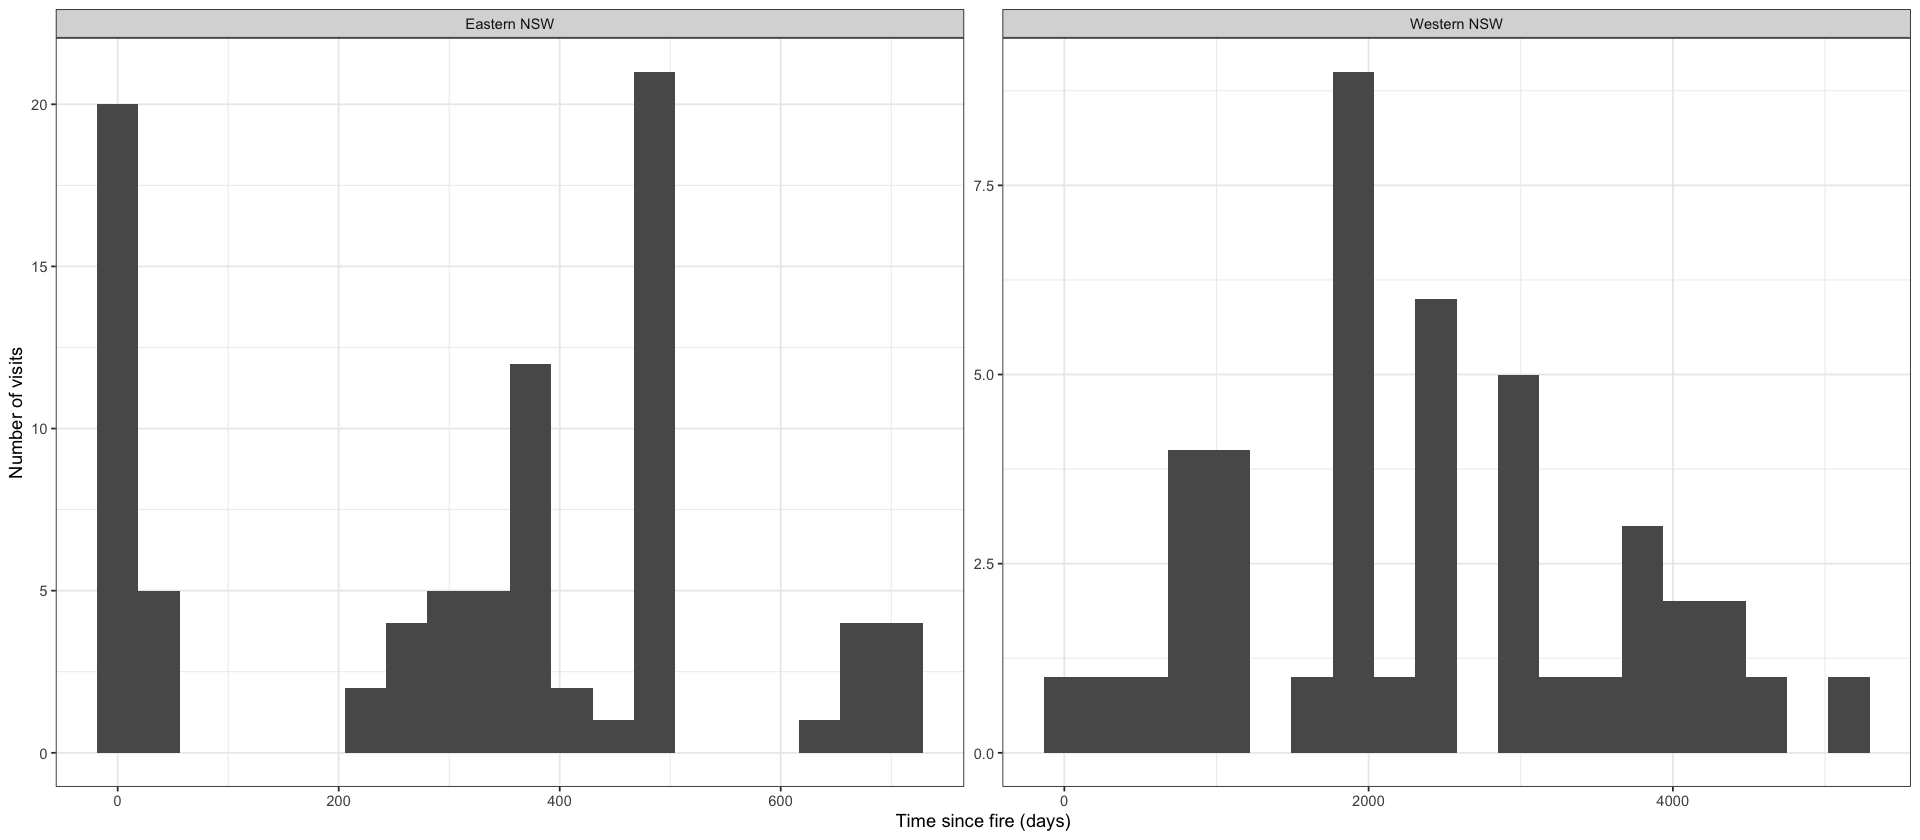

In [26]:
options(repr.plot.width=16) # Make plot larger

ggplot(tsf,
  aes(
    x = time_since_fire,
  )) +
  geom_histogram(bins = 20) +
  facet_wrap(~ legacy, scales ="free") +
  theme(legend.position = "none") +
  labs(x = "Time since fire (days)", y = "Number of visits") +
  theme_bw()

In [24]:
quadrats_table |> head()

,survey_name,visit_id,visit_date,sample_nr,sample_method,quadrat_area,min_fire_date,max_fire_date,species,species_code,⋯,adults_unburnt,resprouts_live,resprouts_died,resprouts_kill,resprouts_reproductive,recruits_live,recruits_died,recruits_reproductive,scorch,life_stage
,<chr>,<chr>,<date>,<int>,<chr>,<dbl>,<date>,<date>,<chr>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,UplandBasalt,CRC09B7UVH,2021-02-03,1,NA,NA,2020-02-10,2020-02-10,Goodenia ovata,3192,⋯,0,0,NA,NA,0,100,NA,0,NA,NA
2,UplandBasalt,CRC09B7UVH,2021-02-03,1,NA,NA,2020-02-10,2020-02-10,Gonocarpus tetragynus,3247,⋯,0,100,NA,NA,0,0,NA,0,NA,NA
3,UplandBasalt,CRC09B7UVH,2021-02-03,1,NA,NA,2020-02-10,2020-02-10,Eucalyptus blaxlandii,4058,⋯,0,0,NA,NA,0,16,NA,0,NA,NA
4,UplandBasalt,CRC09B7UVH,2021-02-03,1,NA,NA,2020-02-10,2020-02-10,Eucalyptus viminalis,4197,⋯,0,0,NA,NA,0,1,NA,0,NA,NA
5,UplandBasalt,CRC09B7UVH,2021-02-03,1,NA,NA,2020-02-10,2020-02-10,Pteridium esculentum,6403,⋯,0,32,NA,NA,0,0,NA,0,NA,NA
6,UplandBasalt,CRC09B7UVH,2021-02-03,1,NA,NA,2020-02-10,2020-02-10,Opercularia aspera,5697,⋯,0,0,NA,NA,0,4,NA,0,NA,NA


In [25]:
nsw <- st_transform(ozmaps::ozmap_states, 4326) %>% filter(NAME == "New South Wales")
okabe <- c("#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

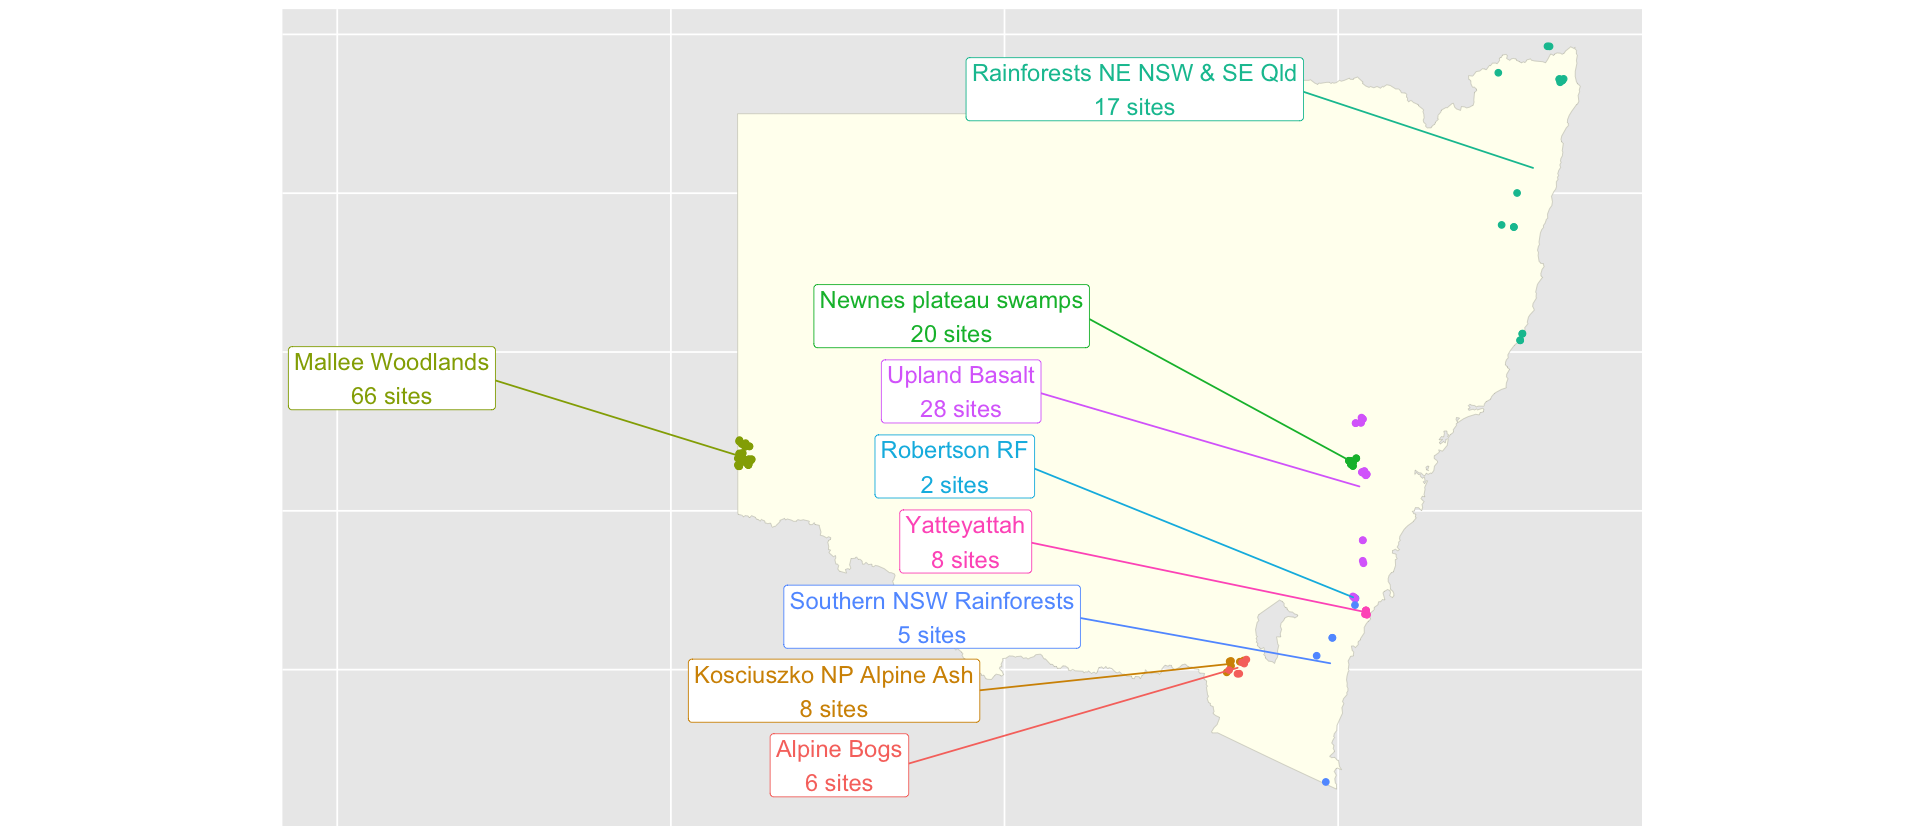

In [26]:
map1 <- ggplot() + 
    geom_sf(data=nsw,fill='ivory1',colour='ivory3') +
    geom_sf(data=field_surveys,aes(colour=survey_name)) + 
  geom_label_repel(data=xys,
                   size=5,
                   nudge_x = -6,
                   nudge_y = 1,
                   direction = "y",
                aes(label=survey_desc
                    , colour=survey_name,x=X,y=Y)) +
  #theme_bw() +
  theme(legend.position = "none",
        axis.title.x = element_blank(),
        axis.title.y = element_blank(),
        axis.text.x=element_blank(), #remove x axis labels
        axis.ticks.x=element_blank(), #remove x axis ticks
        axis.text.y=element_blank(),  #remove y axis labels
        axis.ticks.y=element_blank()  #remove y axis ticks
        )
map1

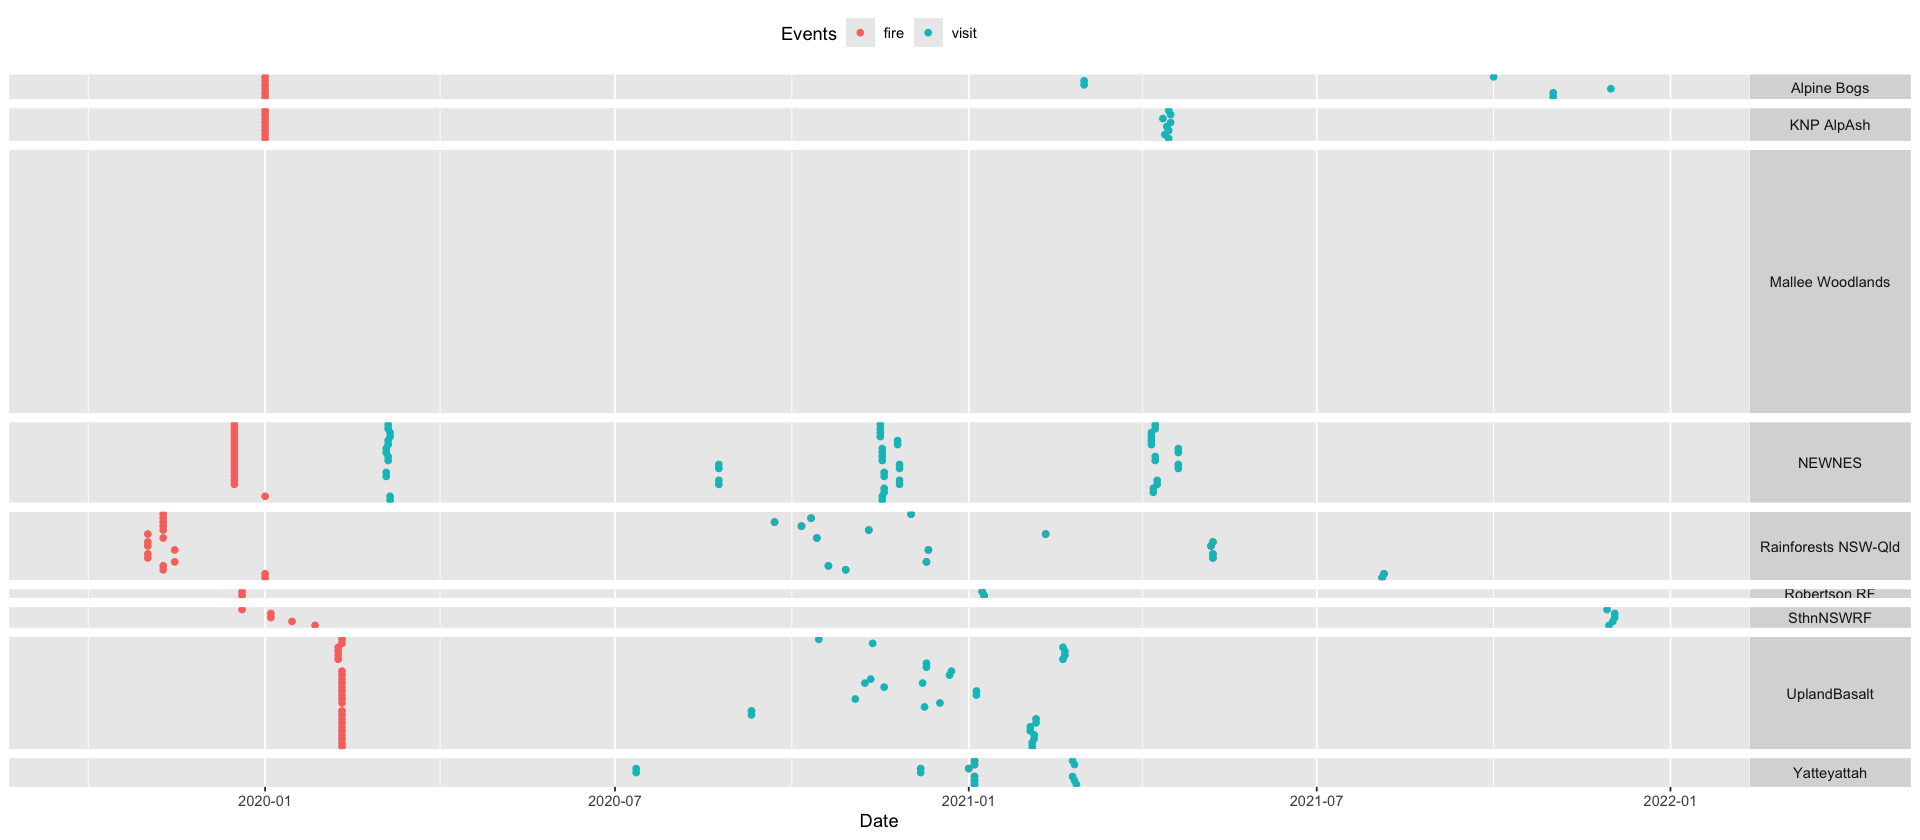

In [27]:


fire1 <- ggplot(fire_visits_data) + 
    geom_point(aes(x=date, y=site_label, colour=event)) +
  facet_grid(survey_name ~ ., scales="free", space="free") +
#  coord_polar(theta="y", start=0,direction=1) +
    coord_cartesian(xlim=as.Date(c('2019-10-01','2022-01-01'))) +
  #theme_linedraw() +
    labs(x = "Date", colour = "Events") +
  scale_y_discrete(breaks=NULL) +
  theme(legend.position = "top",
        panel.grid.minor.y = element_blank(),
        axis.title.y = element_blank(),
        axis.text.y = element_blank(), #remove x axis labels
        strip.text.y.right = element_text(angle = 0)
        )
fire1

In [28]:

ggarrange(fire1,fire2)

ERROR: Error in eval(expr, envir, enclos): object 'fire2' not found


In [ ]:
included <- c("Mallee Woodlands")
field_surveys <- site_locs %>% 
         filter(survey_name %in% included)
survey_cts <- field_surveys %>% 
  group_by(survey_name,survey_description) %>% 
  summarise(
    nsites=n(),
    geom=st_union(geom),.groups='keep') %>% 
  st_centroid 
xys <- st_coordinates(survey_cts) %>% data.frame()
xys$survey_name <- survey_cts$survey_name
xys$survey_desc <- survey_cts %>% 
  transmute(
    description=sprintf(
      "%s\n%s sites",
      survey_description, nsites
      )) %>%
  pull(description)
            

In [ ]:
                                 
map2 <- ggplot() + 
    geom_sf(data=nsw,fill='ivory1',colour='ivory3') +
    geom_sf(data=field_surveys,aes(colour=survey_name)) + 
  geom_label_repel(data=xys,
                   size=6,
                   nudge_x = 5,
                aes(label=survey_desc
                    , colour=survey_name,x=X,y=Y)) +
  #theme_minimal() +
  theme(legend.position = "none",
        axis.title.x = element_blank(),
        axis.title.y = element_blank(),
        axis.text.x=element_blank(), #remove x axis labels
        axis.ticks.x=element_blank(), #remove x axis ticks
        axis.text.y=element_blank(),  #remove y axis labels
        axis.ticks.y=element_blank()  #remove y axis ticks
        )

In [ ]:
fire_visits_data_Mallee <- firehistory_table %>% 
  transmute(site_label,date=earliest_date,event='fire') %>%
  bind_rows(
    visits_table %>% 
      transmute(site_label,date=visit_date,event='visit')
    ) %>% 
  right_join(field_surveys %>% st_drop_geometry, 
             by="site_label", relationship="many-to-one") %>%
  filter(
    date < '2019-01-01'
         )

fire2 <- ggplot(fire_visits_data) + 
    geom_point(aes(x=date, y=site_label, colour=event)) +
  facet_grid(survey_name ~ ., scales="free", space="free") +
#  coord_polar(theta="y", start=0,direction=1) +
    coord_cartesian(xlim=as.Date(c('2000-10-01','2019-01-01'))) +
  #theme_linedraw() +
    labs(x = "Date", colour = "Events") +
  scale_y_discrete(breaks=NULL) +
  theme(legend.position = "top",
        panel.grid.minor.y = element_blank(),
        axis.title.y = element_blank(),
        axis.text.y = element_blank(), #remove x axis labels
        strip.text.y.right = element_text(angle = 0)
        )